In [1]:
# 导入相关模块
import torch
import torch.nn as nn

### 定义编码器
class Encoder(nn.Module):
    def __init__(self, image_channel=1, output_channel=64, hidden_dim=32):
        super(Encoder, self).__init__()
        self.z_dim = output_channel
        # 编码器结构
        # 由两个连续的编码块和一个卷积层组成
        self.enc = nn.Sequential(
            self.encoder_block(image_channel, hidden_dim),
            self.encoder_block(hidden_dim, hidden_dim * 2),
            nn.Conv2d(hidden_dim * 2, output_channel * 2, kernel_size=4, stride=2)
        )
    
    # 定义编码块结构
    def encoder_block(self, input_c, output_c, kernel_size=4, stride=2):
        return nn.Sequential(
            nn.Conv2d(input_c, output_c, kernel_size, stride),
            nn.BatchNorm2d(output_c),
            nn.LeakyReLU(0.1, inplace=True),
        )
    
    # 编码器前向计算流程
    def forward(self, x):
        # 编码预测结果
        enc_res = self.enc(x)
        # 结果重塑
        enc_res = enc_res.view(len(enc_res), -1)
        # 返回均值和方差两个编码结果
        return enc_res[:, :self.z_dim], enc_res[:, self.z_dim:].exp()

In [2]:
### 定义解码器
class Decoder(nn.Module):   
    def __init__(self, z_dim=64, image_channel=1, hidden_dim=128):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        # 解码器结构
        # 由三个连续的转置卷积解码块和一个转置卷积层组成
        self.dec = nn.Sequential(
            self.decoder_block(z_dim, hidden_dim * 4),
            self.decoder_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.decoder_block(hidden_dim * 2, hidden_dim),
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dim, image_channel, kernel_size=4, stride=2),
                nn.Sigmoid()
            )
        )
    
    # 定义解码块结构
    def decoder_block(self, input_c, output_c, kernel_size=3, stride=2):
        return nn.Sequential(
            nn.ConvTranspose2d(input_c, output_c, kernel_size, stride),
            nn.BatchNorm2d(output_c),
            nn.ReLU(inplace=True),
        )

    # 解码器前向计算流程
    def forward(self, x):  
        x = x.view(len(x), self.z_dim, 1, 1)
        return self.dec(x)

In [3]:
# 导入torch正态分布模块
from torch.distributions.normal import Normal

### 基于编解码定义VAE
class VAE(nn.Module):  
    def __init__(self, z_dim=64, image_channel=1):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        # 编码器
        self.encoder = Encoder(image_channel, z_dim)
        # 解码器
        self.decoder = Decoder(z_dim, image_channel)
        
    # VAE前向计算过程
    def forward(self, x):
        # 编码器获取均值和方差
        n_mean, n_var = self.encoder(x)
        # 由均值和方差定义正态分布
        normal_dist = Normal(n_mean, n_var)
        # 从正态分布中抽样
        z_sample = normal_dist.rsample() 
        # 解码为重构图像
        dec_res = self.decoder(z_sample)
        return dec_res, normal_dist

In [4]:
# 导入torch KL散度模块
from torch.distributions.kl import kl_divergence
# 重构损失
reconstruction_loss = nn.BCELoss(reduction='sum')
# 定义KL散度损失
def kl_loss(normal_dist):
    return kl_divergence(
        normal_dist, Normal(torch.zeros_like(normal_dist.mean), torch.ones_like(normal_dist.stddev))
    ).sum(-1)

In [5]:
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data.dataloader import DataLoader
# 下载Fashion MNIST数据集
FashionMnist_dataset = datasets.FashionMNIST('./data', train=True, transform=T.ToTensor(), download=True)
# 导入Fashion MNIST数据集
dataloader = DataLoader(FashionMnist_dataset, shuffle=True, batch_size=256)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...


/root/miniconda3/envs/myconda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


epoch [1/30], loss:25083.451


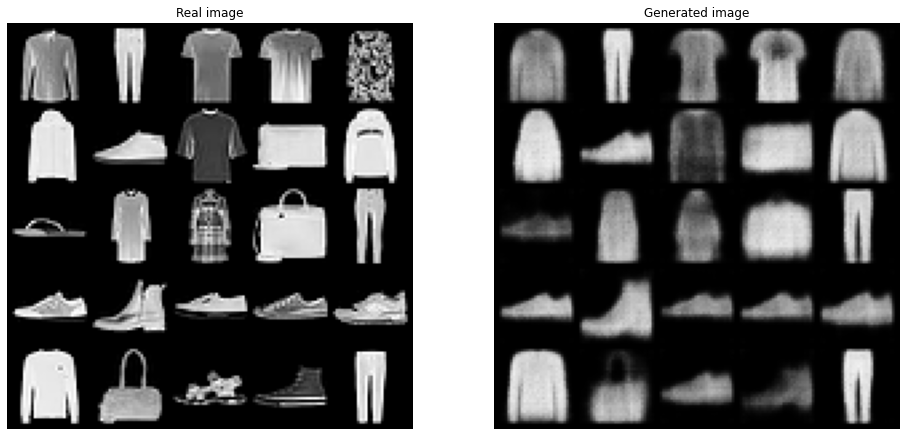

epoch [2/30], loss:24030.240


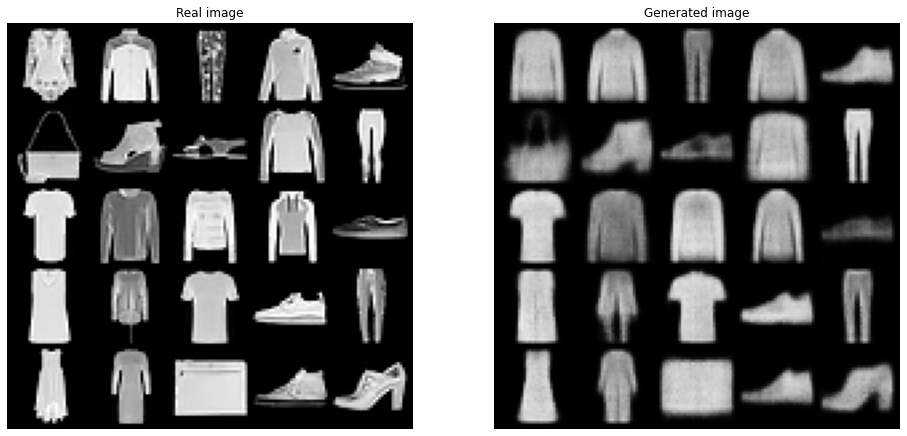

epoch [3/30], loss:24465.273


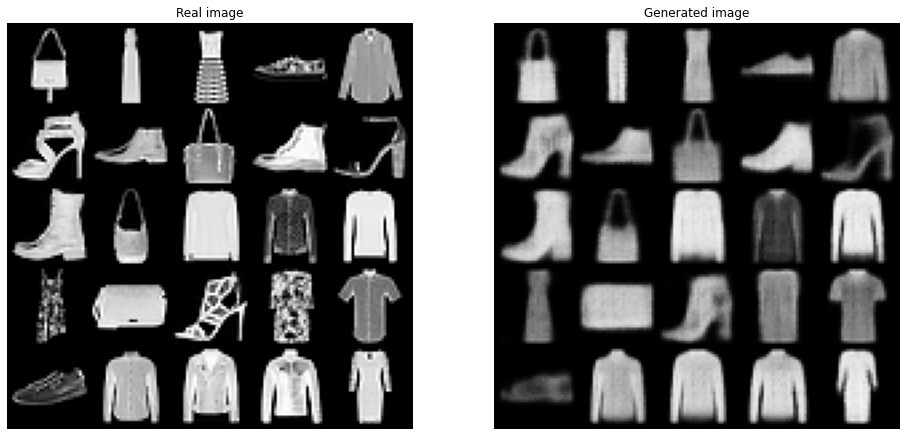

epoch [4/30], loss:25101.264


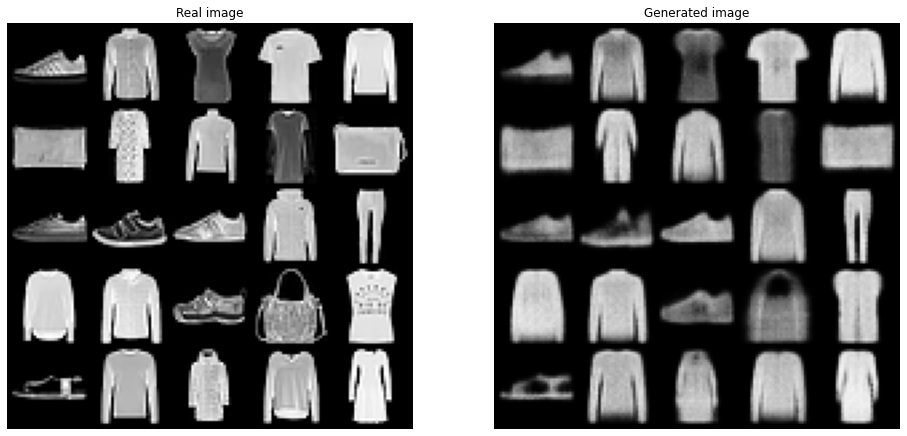

epoch [5/30], loss:23096.869


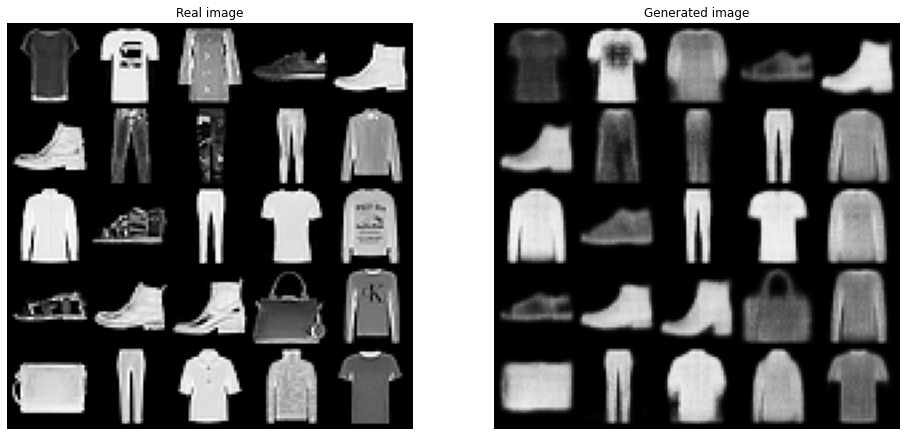

epoch [6/30], loss:24454.760


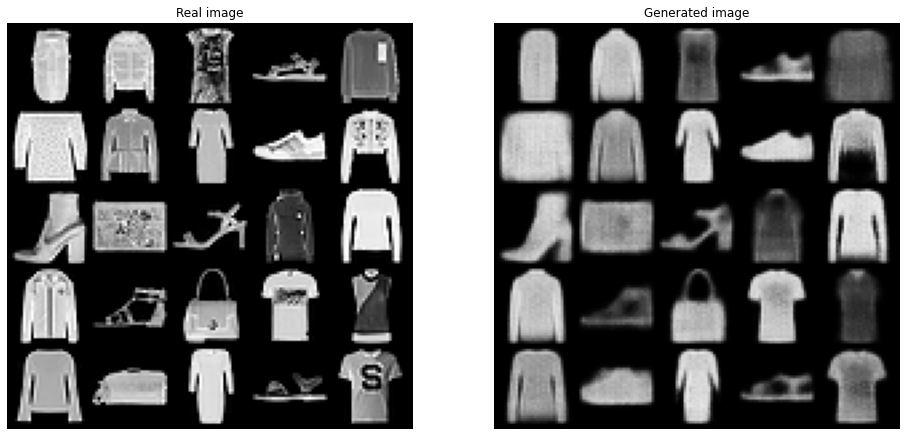

epoch [7/30], loss:23878.457


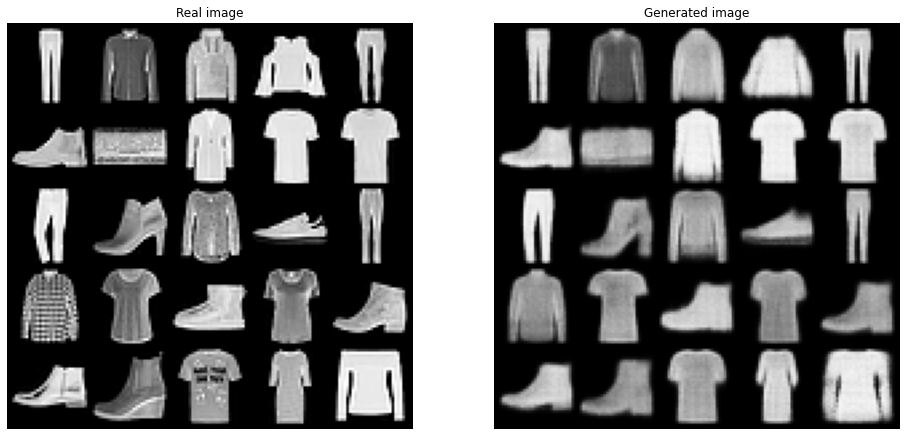

epoch [8/30], loss:22578.176


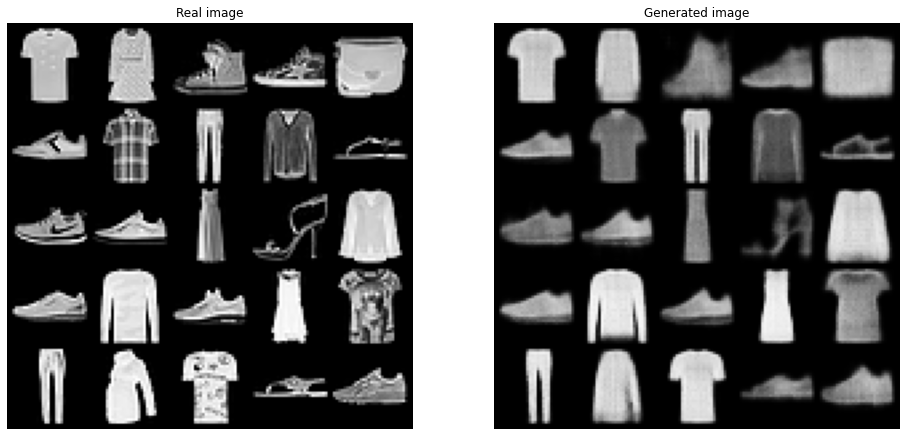

epoch [9/30], loss:22382.316


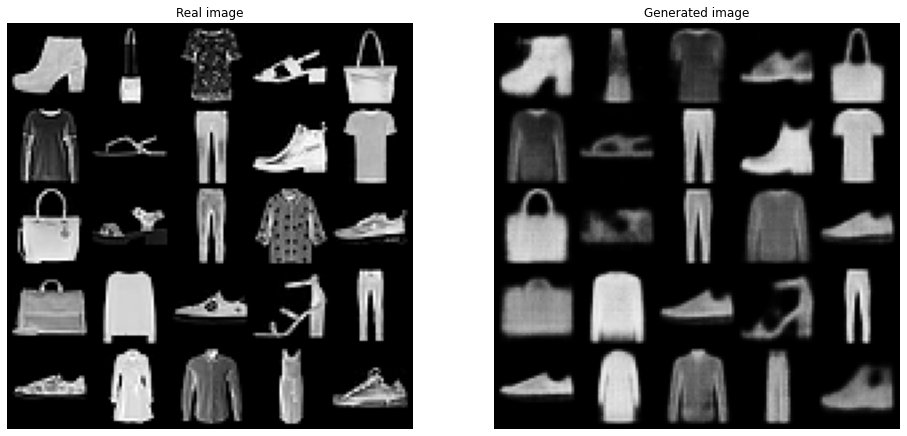

epoch [10/30], loss:24005.967


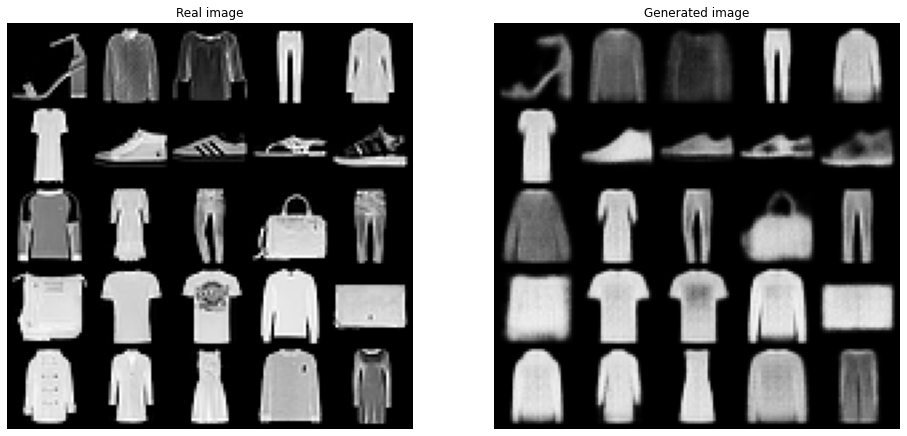

epoch [11/30], loss:23842.115


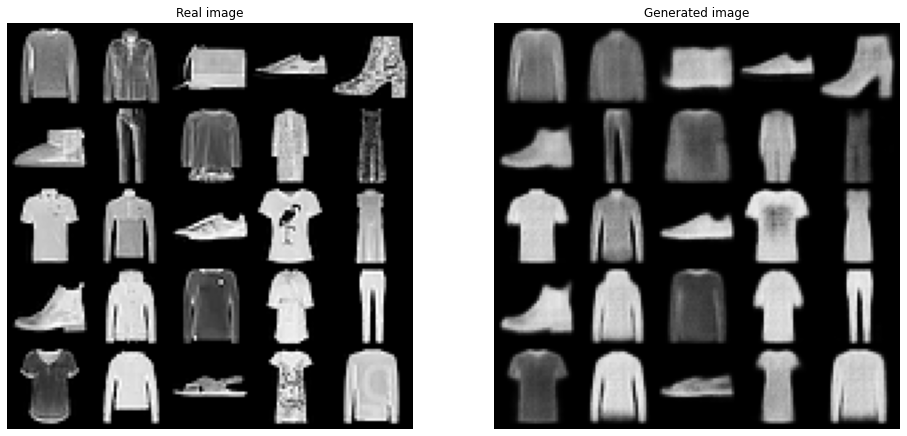

epoch [12/30], loss:23761.402


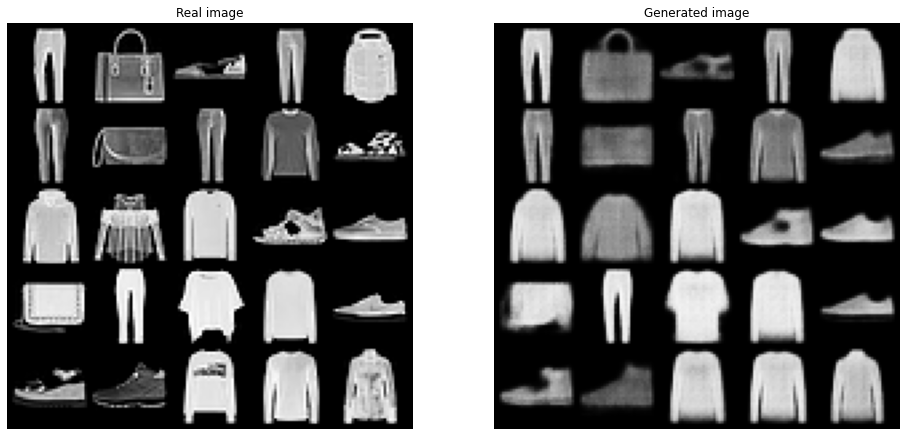

epoch [13/30], loss:22498.934


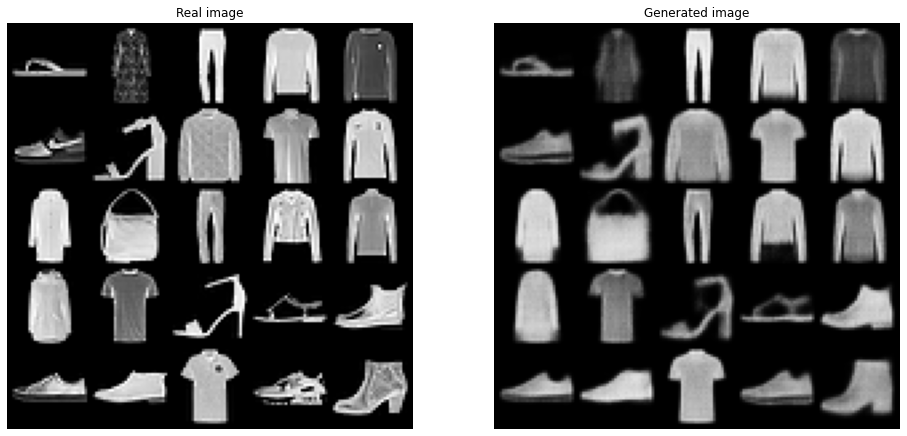

epoch [14/30], loss:23985.699


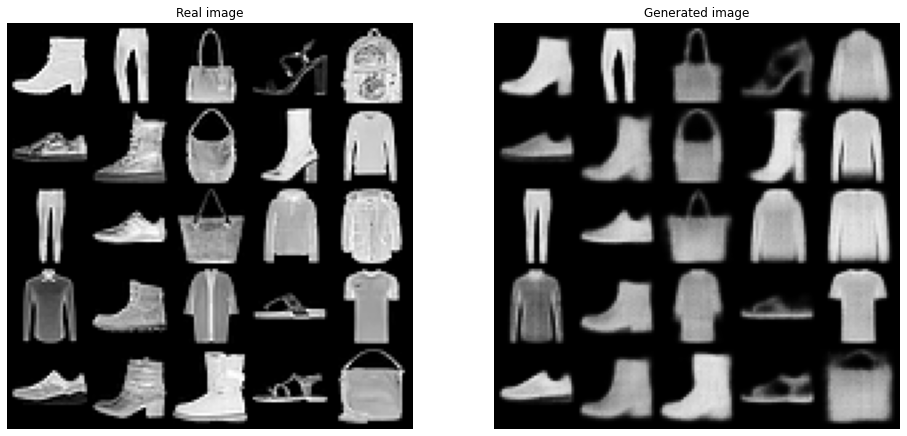

epoch [15/30], loss:22748.867


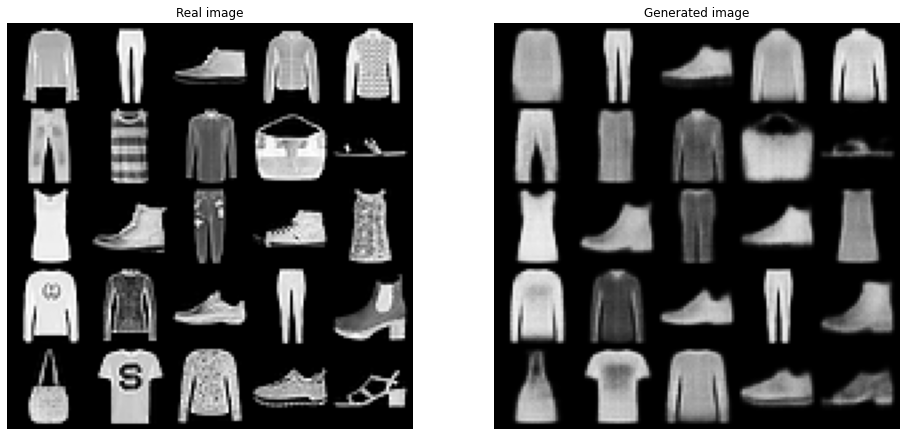

epoch [16/30], loss:23392.146


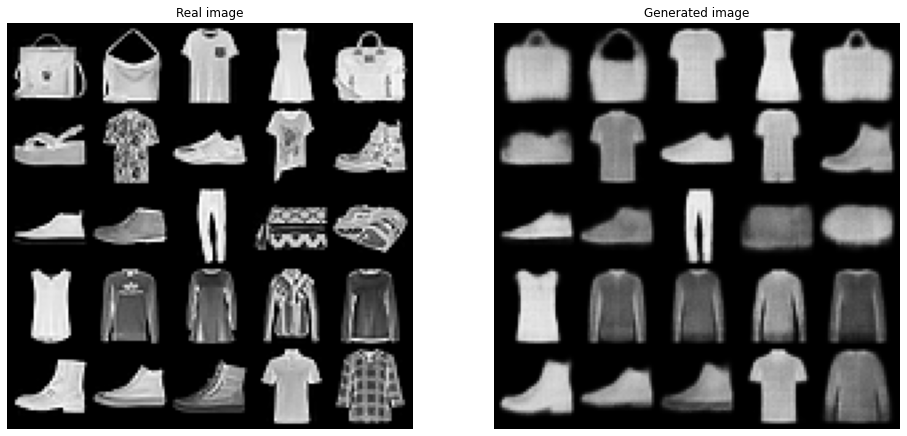

epoch [17/30], loss:22326.885


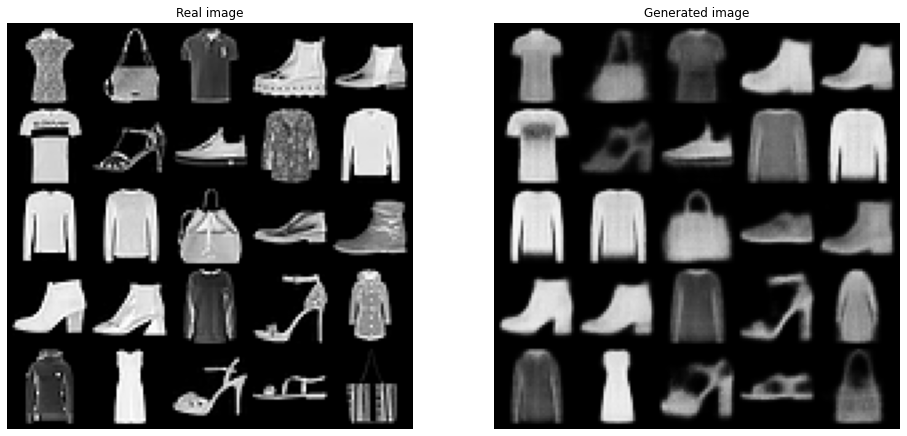

epoch [18/30], loss:24579.498


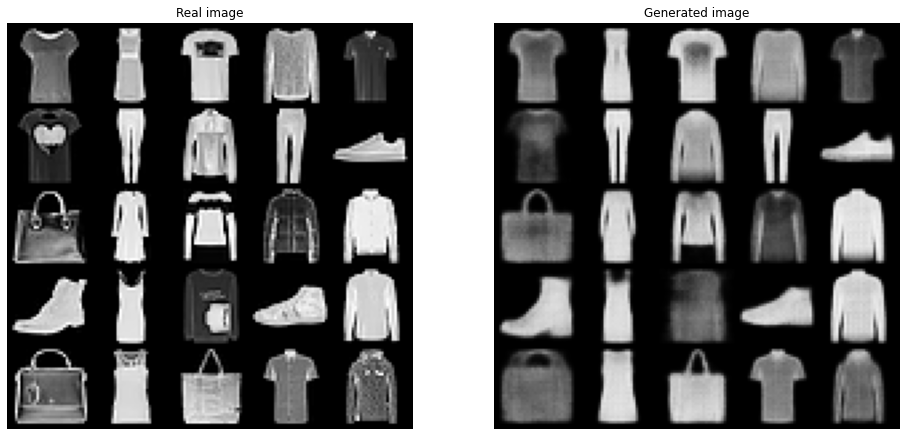

epoch [19/30], loss:23275.354


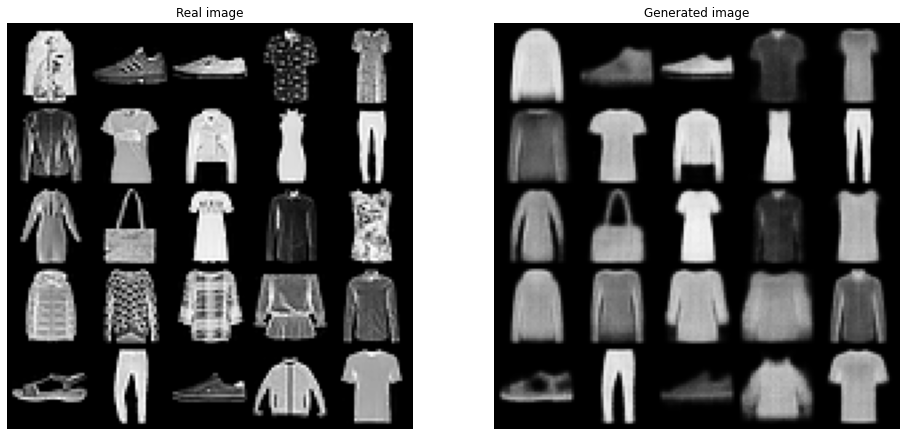

epoch [20/30], loss:22811.500


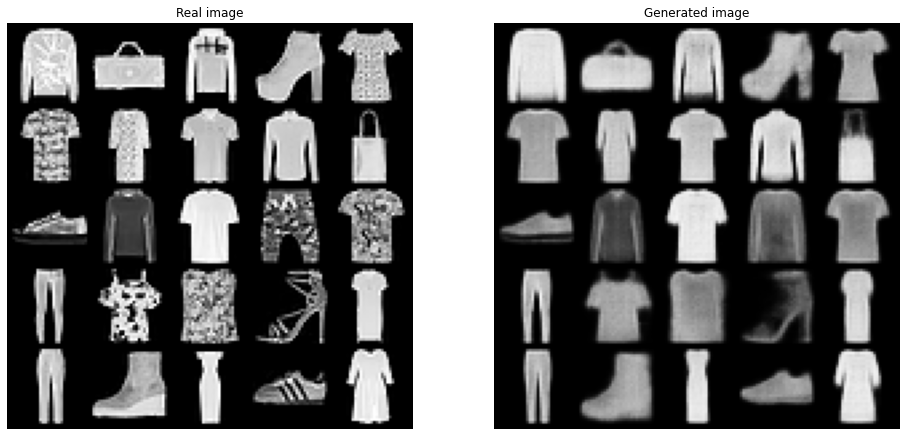

epoch [21/30], loss:22678.119


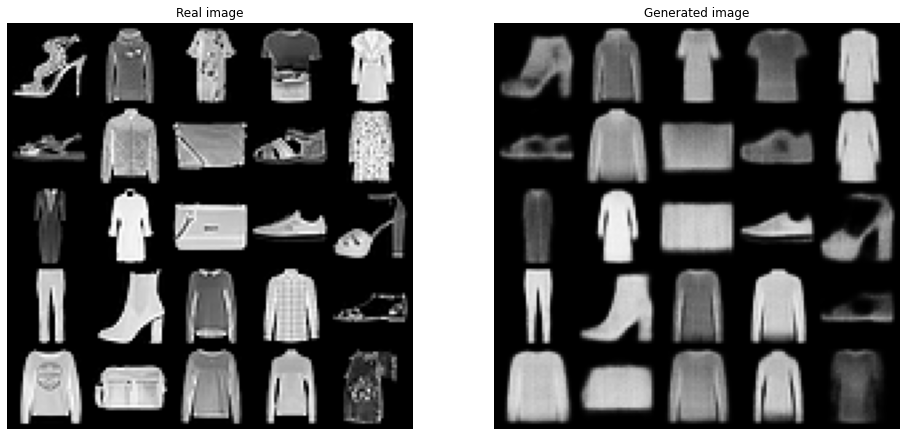

epoch [22/30], loss:23545.518


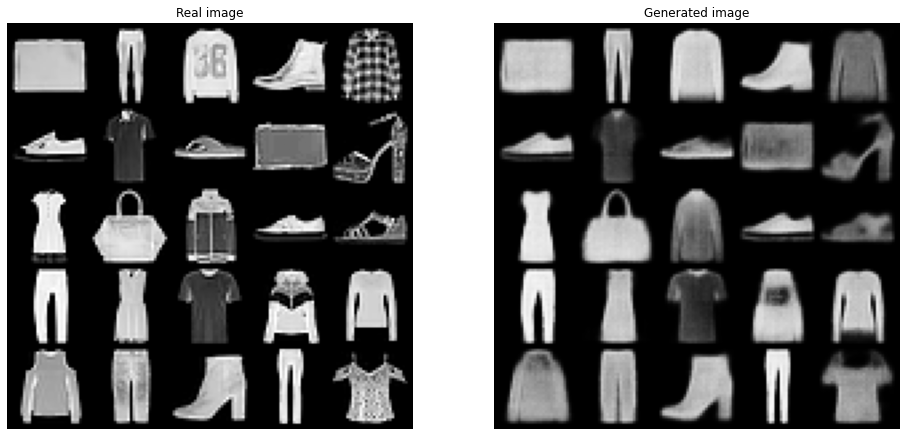

epoch [23/30], loss:24015.404


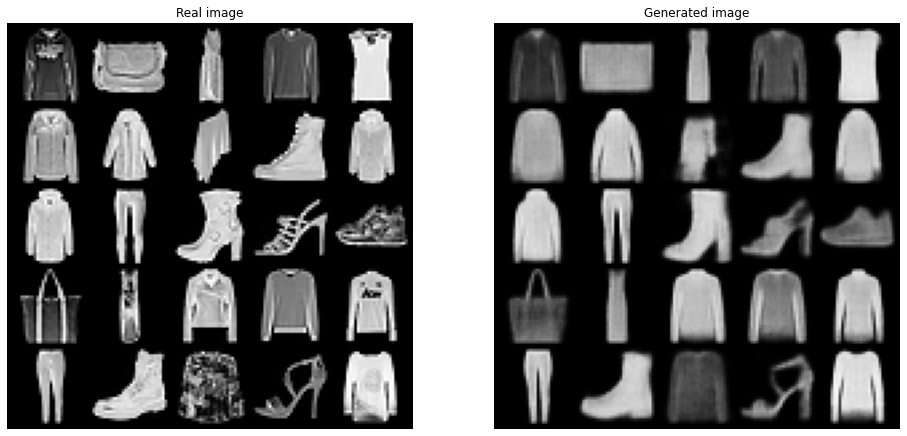

epoch [25/30], loss:23893.773


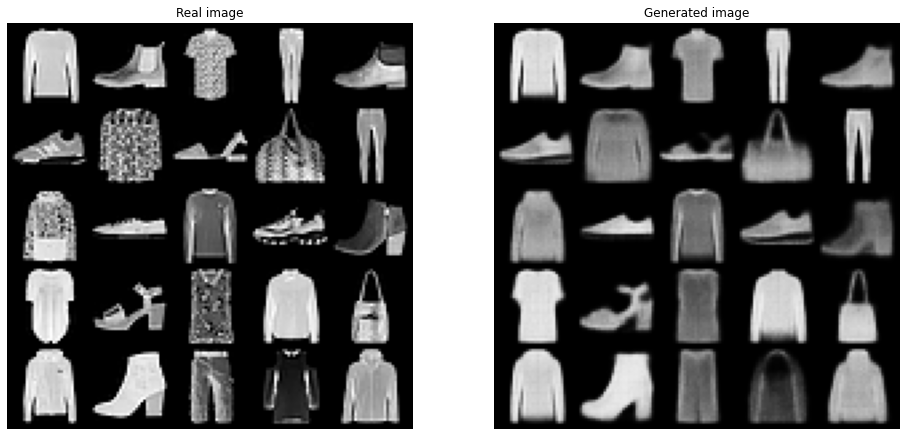

epoch [26/30], loss:22458.520


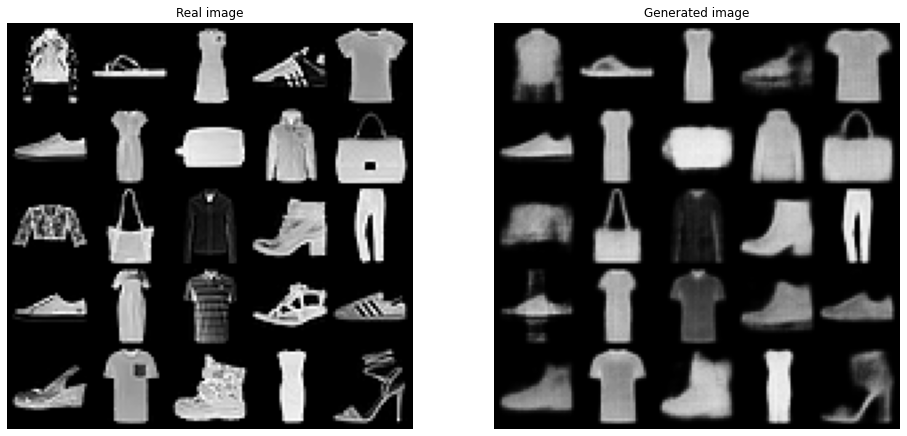

epoch [27/30], loss:22620.678


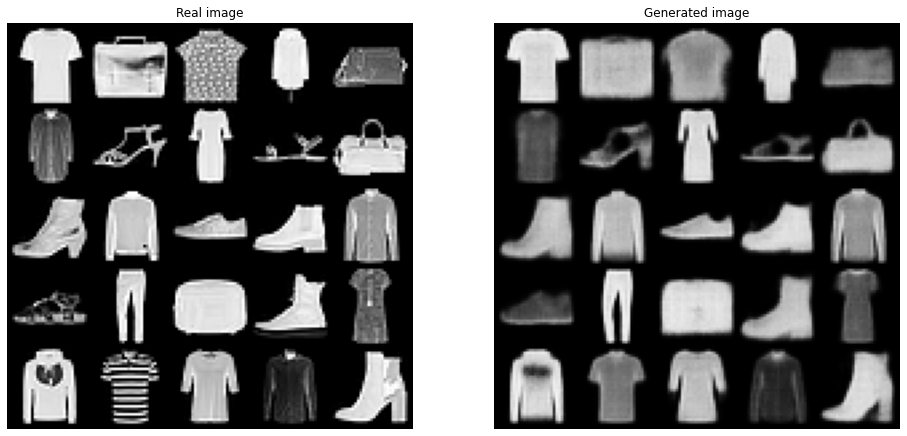

epoch [28/30], loss:24570.498


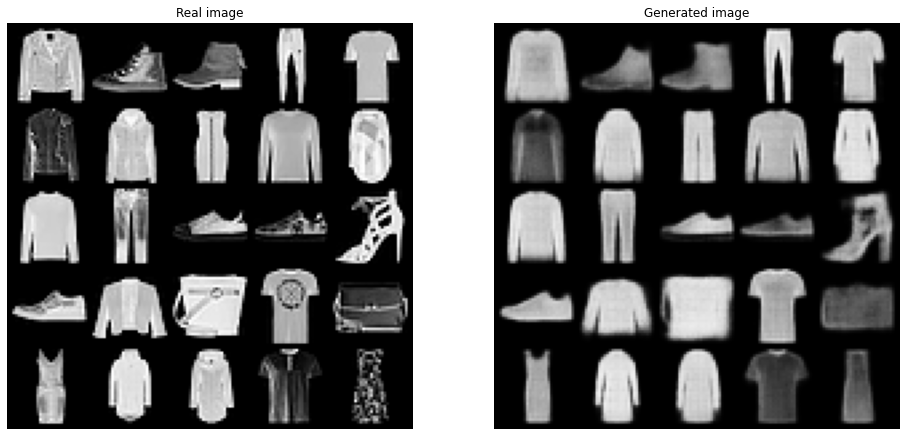

epoch [29/30], loss:22519.246


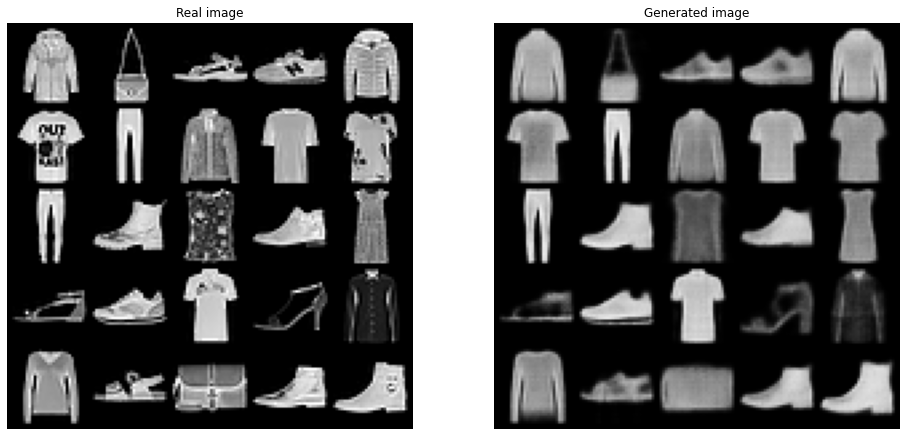

epoch [30/30], loss:23171.010


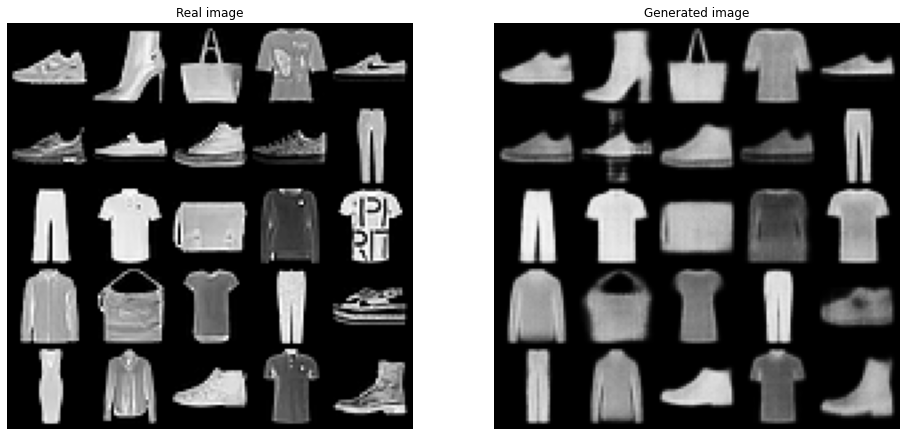

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
plt.rcParams["figure.figsize"] = (16, 8)

# 定义显示图像阵列函数
def plot_image_grid(image, num_images=25, size=(1, 28, 28)):
    image = image.detach().cpu()
    image_grid = make_grid(image[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

vae = VAE().to('cuda')
num_epochs = 30
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# 执行VAE训练
mean_loss = 0
for epoch in range(num_epochs):
    for _, (images, _) in enumerate(dataloader):
        images = images.to('cuda')
        optimizer.zero_grad() 
        dec_img, normal_dist = vae(images)
        loss = reconstruction_loss(dec_img, images) + kl_loss(normal_dist).sum()
        loss.backward()
        optimizer.step()
        
    # 打印训练损失
    print('epoch [{}/{}], loss:{:.3f}'.format(epoch + 1, num_epochs, loss.item()))
    # 显示5*5图像阵列
    plt.subplot(1,2,1)
    plot_image_grid(images)
    plt.title("Real image")
    plt.subplot(1,2,2)
    plot_image_grid(dec_img)
    plt.title("Generated image")
    plt.show()